# Digital Signal Processing - 7

## Window functions

For analog signals or for a timeless discrete sinusoidal signal, its spectrum is a delta function at the frequency of this signal. In practice, the spectrum of a real time-limited harmonic signal is equivalent to the function ~ $ \frac {sin(x)} {x} = sinc(x) $, and the width of the main lobe depends on the duration of the signal analysis interval $ T $. The time limit is nothing more than multiplying the signal by a rectangular envelope.

From previous lectures, we learned that the multiplication of signals in the time domain is the convolution of their spectra in the frequency domain (and vice versa: the convolution of signals in the time domain is the product of their spectra). In this regard, the spectrum of the bounded rectangular envelope of the harmonic signal is equivalent to ~ $ sinc(x) $. This is also due to the fact that we cannot integrate the signal over an infinite time interval, and the Fourier transform in discrete form, expressed through a finite sum, is limited by the number of samples.

As a rule, the FFT length in modern digital processing devices takes $ N_{FFT} $ values from 8 to several million points. By limiting the signal to the interval $ N $, we thereby impose a rectangular “window” with a duration of $ N $ samples. Therefore, the resulting spectrum is the spectrum of the multiplied harmonic signal and the rectangular envelope.

Let's move on to the example. We construct the spectrum of a short harmonic signal with the following parameters: signal length $ N = 256 $, FFT length - $ N_{FFT} = 2048 $. For clarity, the spectrum graph is presented on a logarithmic scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift
import scipy.signal as sig

%matplotlib inline

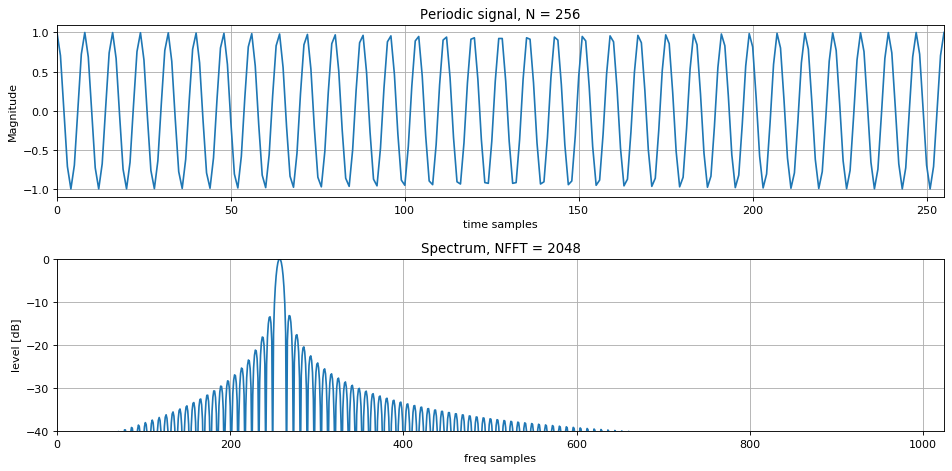

In [2]:
# Input parameters
N = 256
NFFT = 2048

# Input signal (long: N >> NFFT)
tt = np.linspace(0, 1, N, endpoint=True)
xx = np.cos(2*np.pi*32*tt)

# Calculate FFT
sft = np.abs(fft(xx, NFFT))
slg = 20*np.log10(sft / np.max(sft))

plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(2,1,1)
plt.title('Periodic signal, N = {}'.format(N))
plt.xlabel('time samples')
plt.ylabel('Magnitude')
plt.plot(xx)
plt.xlim([0, N-1])
plt.grid(True)

plt.subplot(2,1,2)
plt.title('Spectrum, NFFT = {}'.format(NFFT))
plt.xlabel('freq samples')
plt.ylabel('level [dB]')
plt.plot(slg)
plt.xlim([0, NFFT//2])
plt.ylim([-40, 0])
plt.grid(True)
plt.tight_layout()

As you can see, the spectrum of a short harmonic signal in real life is not equivalent to the delta function, but is similar to the convolution of the spectra of a rectangular signal and a harmonic signal. The graph shows the first half of the frequency domain. The resulting signal is symmetrical with respect to half the sampling frequency or the $ N_{FFT} / 2 $ parameter.

Recall that the spectrum of a rectangular signal is equivalent to the expression ~ $ \frac {sin(x)} {x} = sinc(x) $. That is, at the frequency of the signal, the spectrum of the rectangular window is superimposed on the delta function. As the duration of the harmonic signal increases in the time domain, its spectrum tends to the delta function at the frequency of this signal, and the influence of the rectangular window decreases.

That is, the time limit of the signal leads to the imposition of a rectangular “window”. In the example below, the signal duration is significantly increased $ N = 65536 $. As you can see, the spectrum of such a signal tends to a delta function.

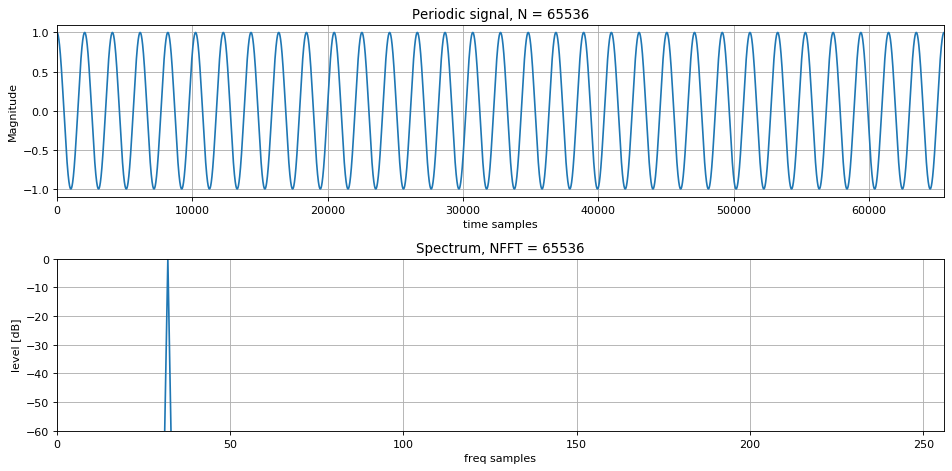

In [3]:
# Input parameters
N = 65536

# Input signal (long: N >> NFFT)
tt = np.linspace(0, 1, N, endpoint=True)
xx = np.cos(2*np.pi*32*tt)

# Calculate FFT
sft = np.abs(fft(xx, N))
slg = 20*np.log10(sft / np.max(sft))

plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(2,1,1)
plt.title('Periodic signal, N = {}'.format(N))
plt.xlabel('time samples')
plt.ylabel('Magnitude')
plt.plot(xx)
plt.xlim([0, N-1])
plt.grid(True)

plt.subplot(2,1,2)
plt.title('Spectrum, NFFT = {}'.format(N))
plt.xlabel('freq samples')
plt.ylabel('level [dB]')
plt.plot(slg)
plt.xlim([0, N//256])
plt.ylim([-60, 0])
plt.grid(True)
plt.tight_layout()

Unfortunately, in real life and in practice, the use of infinite signals is impossible and time-consuming:

- Very long signals require large amounts of memory to store values.
- Long signals contain more energy than short signals, ceteris paribus, which in turn makes it difficult to transmit and receive such signals.
- Long signals require more computing resources to process them (convolution, filtering, Fourier transform).
- Long pulses are subject to greater distortion than short ones due to the increased propagation duration in the physical medium.

When a signal is multiplied by a rectangular window (truncating a long sequence to a real signal), the so-called “spreading of the spectrum” or “blurring” of the spectrum occurs. The main problem of spectrum blurring is that the side lobes of a stronger signal can mask weak signals. Below we will show how to use the window functions to reduce the influence of spreading of the spectrum.

### Window Functions

In problems of digital signal processing, windows of various shapes were invented, which, when superimposed on a signal in the time domain, can qualitatively improve its spectral characteristics. A large number of various windows is due primarily to one of the main features of any window overlay. This feature is expressed in the relationship between the level of the side lobes and the width of the central lobe.

**Rule: the stronger the suppression of the side lobes of the spectrum, the wider the main lobe of the spectrum, and vice versa**

Imagine a signal that is divided into several sequences, each of which is processed independently, and then stitched into a single signal. When calculating an FFT, a rectangular window is superimposed. Therefore, the subsequent restoration of the waveform will lead to undesirable effects, which are expressed in distortion of the waveform at the joints (bursts of the signal). In order to smooth out these bursts, you can apply window filtering.

One of the applications of window functions: detection of weak signals against the background of stronger ones by suppressing the level of side lobes. The main window functions in DSP tasks are **triangular, sinusoidal, Lanczos, Hann, Hamming, Blackman, Harris, Blackman-Harris window, flat-top window, Natall, Gauss, Kaiser window** and many others. Most of them are expressed through a finite series by summing harmonic signals with specific weights. Such signals are perfectly implemented in practice on any hardware devices (programmable logic circuits or signal processors).

Windows of complex shape are calculated by taking an exponent (Gaussian window) or a modified Bessel function (Kaiser window). Such window functions are more difficult to implement in integrated circuits (to calculate the functions of the exponent or the Bessel function, an encoding table of one value to another is required).

### Suppression Ratio

Obviously, when the signal is multiplied by the window function, the amplitude of the resulting oscillation changes. In DSP tasks, the concept of attenuation coefficient is introduced, which characterizes signal suppression during window filtering in comparison with a rectangular window. Formula for calculating attenuation coefficient:

$ \beta = \frac{A_{w}}{A_{r}} \cdot \frac{1}{N} \sum_{n=0}^{N-1}w(n)$ , 

Where:
- $ A_{w} $ - level of the constant component of the window function,
- $ A_{r} $ - level of the constant component of a rectangular window,
- $ w(n) $ - samples of the window function,
- $ N $ - the length of the window function.

In [4]:
def dft_win(w):
    """
    Plot window function and spectrum of the window
    
    Parameters
    ----------
    w : np.array
        input window vector
    """
    
    # Find length of window
    N = len(w)
    # FFT size
    NFFT = 2**12
    # Calculate FFT
    W = fftshift(fft(w, NFFT))
    # Find max and add minimum floating-point value (except divide-by-zero)
    W = W / np.amax(W) + np.nextafter(0,1)
    tt = np.linspace(-1, 1, NFFT)

    # plot window function and its spectrum
    fig = plt.figure(figsize=(12, 6), dpi=80)
    
    plt.subplot(2,1,1)
    plt.stem(w, use_line_collection=True, basefmt='C0')
    plt.title('Window fucntion')
    plt.xlabel('Samples')
    plt.ylabel(r'$w[k]$')
    plt.xlim([0, N-1])
    plt.grid(True)
    
    plt.subplot(2,1,2)
    plt.plot(tt, 20*np.log10(np.abs(W)))
    plt.title('Spectrum')
    plt.xlabel('Frequency')
    plt.ylabel('Level in dB')
    plt.axis([-1, 1, -120, 2])
    plt.grid(True)
    plt.tight_layout()

### Basic window functions


The following are expressions for basic window functions. The duration of the window function is $ N $, $ w(n) $ are the samples of the window function. In the Python library `scipy` in the package` signal`, all well-known windows are available. Their challenge is quite simple. Further, in the form of tables and graphs, the comparative effectiveness of various windows will be shown.

**Rule: the sum of the moduli of the coefficients of the window function is equal to unity!**


**Rectangular window**

$ w(n) = 1 $

The simplest window has the worst characteristics and is obtained automatically when the sequence is truncated to $ N $ samples. The maximum level of side lobes (UBL) of the frequency response of a rectangular window: **- 13 dB**.

Python: `signal.boxcar (M)`

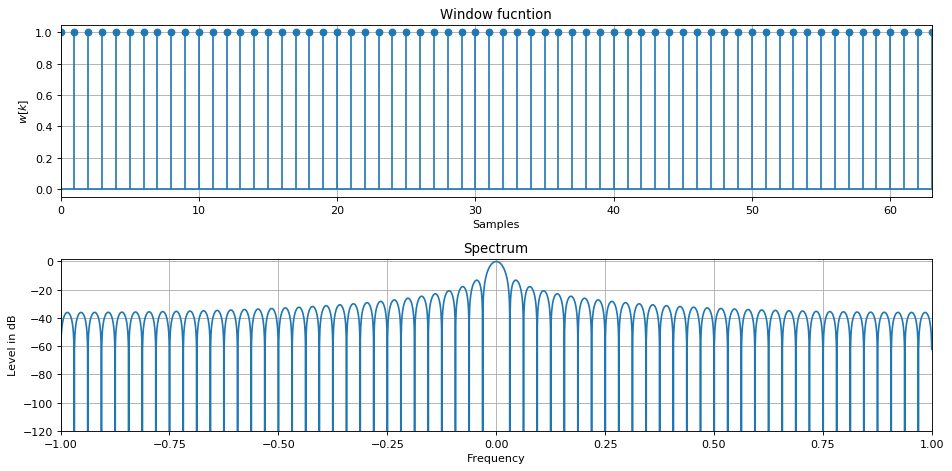

In [5]:
N = 64
dft_win(np.ones(N))

**Triangular window**

Also known as the Bartlett window.

$w(n) = 1 - \frac{n - N / 2}{L / 2}$

Where

$L = N, N+1, N+2 $

Maximum level of side lobes: **- 26 dB**.

Python: `signal.triang (M)` or `bartlett (M)`

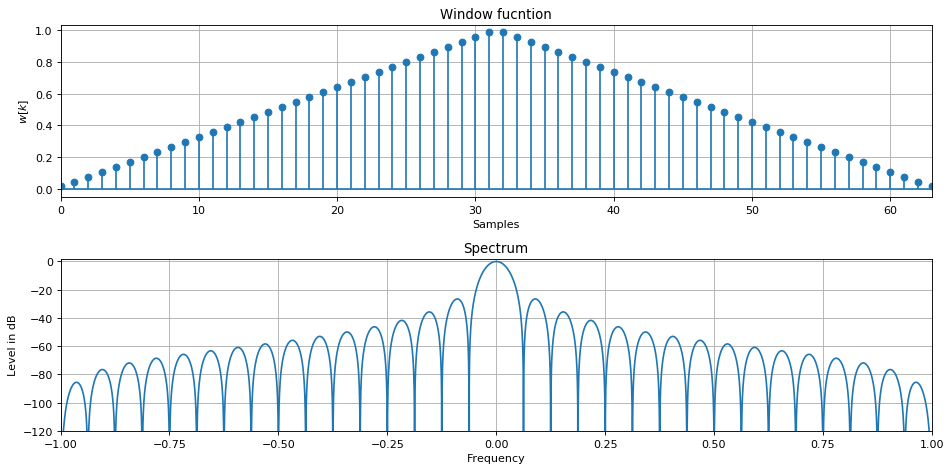

In [6]:
N = 64
dft_win(sig.triang(N))

**Sinus**

$w(n) = sin(\frac{\pi\cdot n}{N-1})$

A simple window in terms of software and hardware implementation. The maximum level of the side lobes of the sinusoidal window: **- 23 dB**.

Python: `signal.cosine (M)`

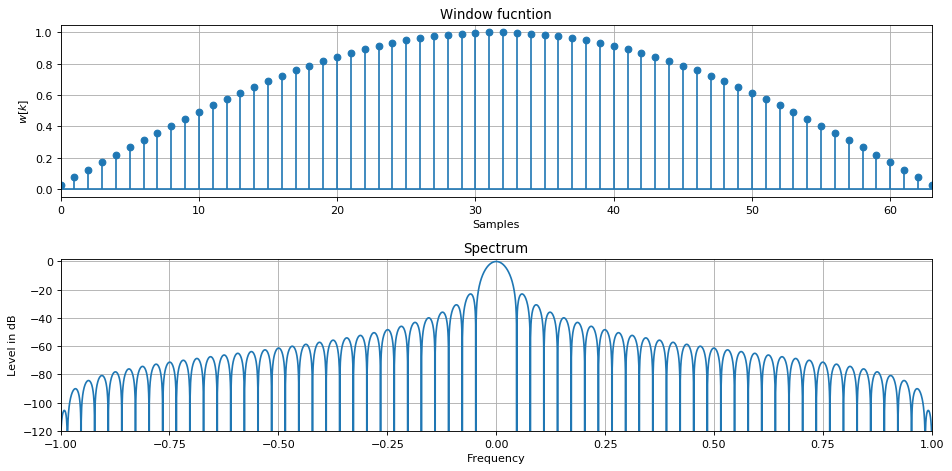

In [7]:
N = 64
dft_win(sig.cosine(N))

**Window Hannah (Henning)**

$w(n) = 0.5 \cdot [1 - cos(\frac{2\pi n}{N-1})]$

This window is also called the second-order Blackman-Harris window. The maximum level of the side lobes of the sinusoidal window: **- 31.5 dB**.

Python: `signal.hann (M)` and `signal.hanning (M)`

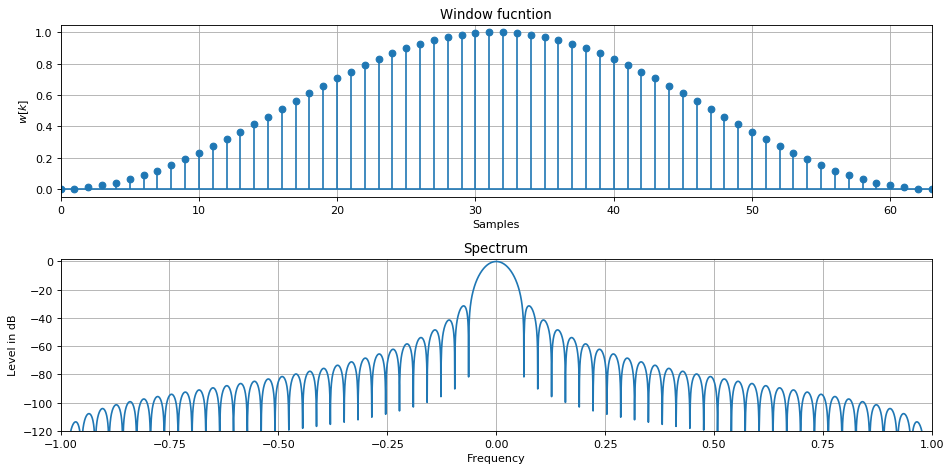

In [8]:
N = 64
dft_win(sig.hann(N))

**Hamming Window**

$w(n) = 0.53836 - 0.46164 \cdot cos(\frac{2\pi n}{N-1})$

Maximum level of side lobes: **- 42 dB**.

Python: `signal.hamming (M)`

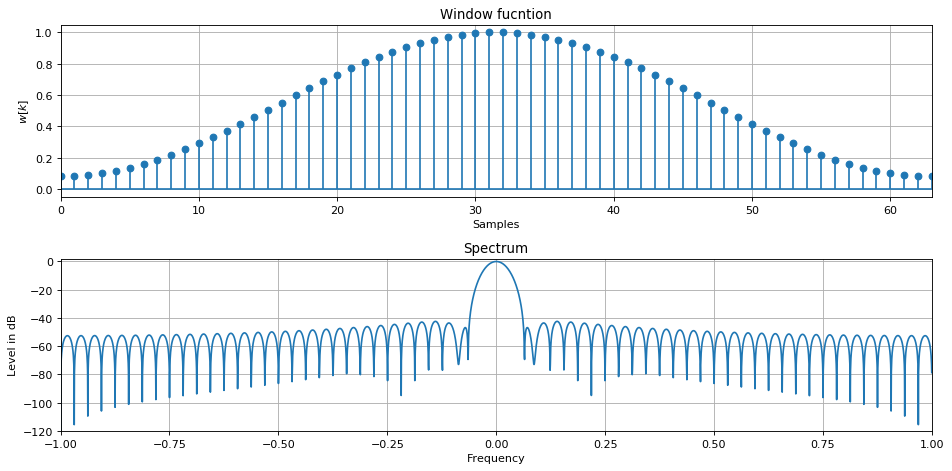

In [9]:
N = 64
dft_win(sig.hamming(N))

**Blackman Window**

$w(n) = a_0 - a_1 \cdot cos(\frac{2\pi n}{N-1}) +  a_2 \cdot cos(\frac{4\pi n}{N-1}) $

Where

$a_0 = \frac{1-\alpha}{2}; a_1 = 0.5 ; a_2 = 0.5\cdot\alpha $

At $ \alpha = 0.16 $ the maximum level of side lobes: **- 58 dB**.

Python: `signal.blackman (M)`

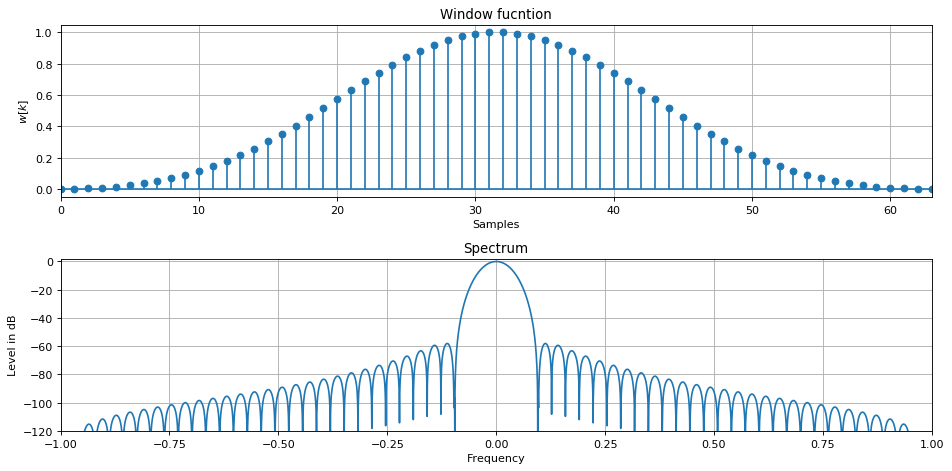

In [10]:
N = 64
dft_win(sig.blackman(N))

**Blackman-Harris Window**

Defined by the sum of four terms (i.e., a fourth-order window).

$w(n) = a_0 - a_1 \cdot cos(\frac{2\pi n}{N-1}) +  a_2 \cdot cos(\frac{4\pi n}{N-1}) - a_3 \cdot cos(\frac{6\pi n}{N-1}) $

Where

$ a_0 = 0.35875, a_1 = 0.48829, a_2 = 0.14128, a_3 = 0.01168 $

Maximum level of side lobes: **- 92 dB**.

Python: `signal.blackmanharris (M)`

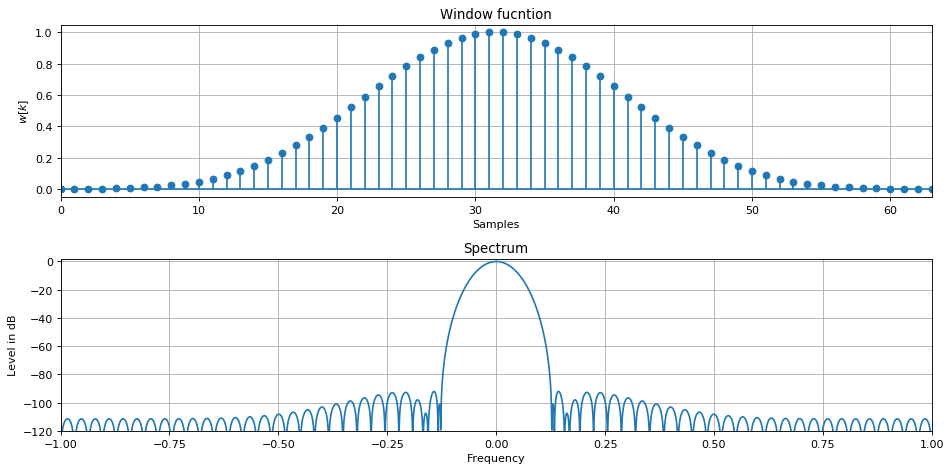

In [11]:
N = 64
dft_win(sig.blackmanharris(N))

**Blackman-Natall Window**

The formula is similar to the Blackman-Harris window. The difference is only in the coefficients. Set by the sum of four terms.

$w(n) = a_0 - a_1 \cdot cos(\frac{2\pi n}{N-1}) +  a_2 \cdot cos(\frac{4\pi n}{N-1}) - a_3 \cdot cos(\frac{6\pi n}{N-1}) $

Where

$ a_0 = 0.3635819, a_1 = 0.4891775, a_2 = 0.1365995, a_3 = 0.0106411 $

Maximum level of side lobes: **- 93 dB**.

Python: `signal.nuttall (M)`

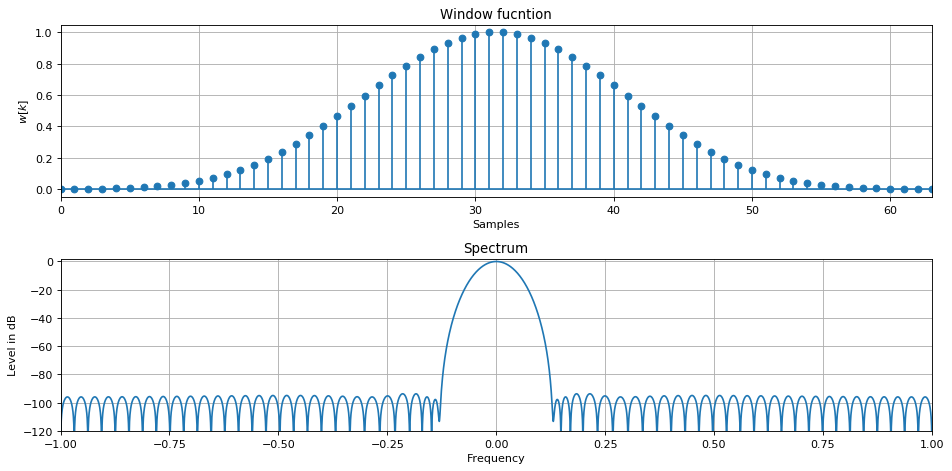

In [12]:
N = 64
dft_win(sig.nuttall(N))

**Flat Top Window**

A window with a flat top (Flat-top window).

$w(n) = a_0 - a_1 \cdot cos(\frac{2\pi n}{N-1}) +  a_2 \cdot cos(\frac{4\pi n}{N-1}) - a_3 \cdot cos(\frac{6\pi n}{N-1}) + a_4 \cdot cos(\frac{8\pi n}{N-1}) $

Where

$ a_0 = 0.21556895, $

$ a_1 = 0.41663158, $

$ a_2 = 0.277263158, $

$ a_3 = 0.083578947, $

$ a_4 = 0.0069474 $

Maximum level of side lobes: **- 70 dB**.

Python: `signal.flattop (M)`

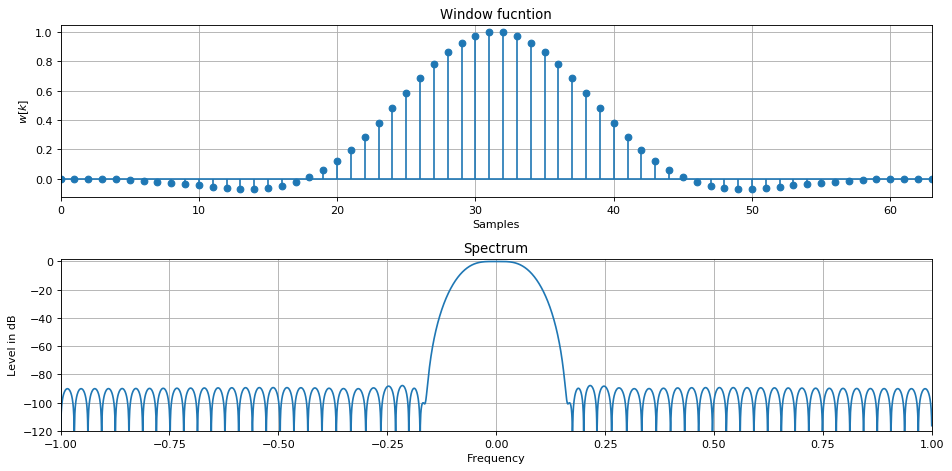

In [13]:
N = 64
dft_win(sig.flattop(N))

** Kaiser Window **

Kaiser window. Varies with the parameter $ \ beta $, which determines the level of attenuation and the slope of the frequency response. The Kaiser window is a kind of universal window with which you can select certain filtering options for a wide class of tasks.

$w(n) = \frac{|I_{0} \sqrt{1 - (\frac{2n-N+1}{N-1})^2} |}{|I_{0}(\beta)|}$

Where

- $ I_{0} $ - a modified Bessel function of the first kind of zero order.
- $ \beta $ - coefficient that determines the fraction of energy concentrated in the main lobe of the spectrum of the window function.

The higher $ \beta $, the greater the fraction of energy inside the main lobe, and the wider the main lobe. Therefore, the lower the level of the side lobes (the better the suppression in filtering tasks). In practice, the Kaiser function in the hardware is practically not implemented, but it is applied programmatically (calculation of FIR filter coefficients). In real problems, $ \beta $ values from 5 to 11 are used.

Python: `signal.kaiser (M, beta)`

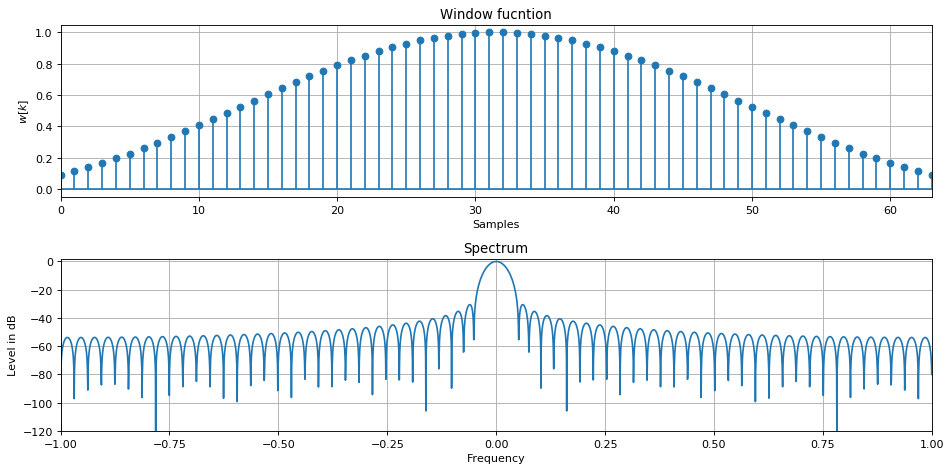

In [14]:
N = 64
dft_win(sig.kaiser(N, beta=4))

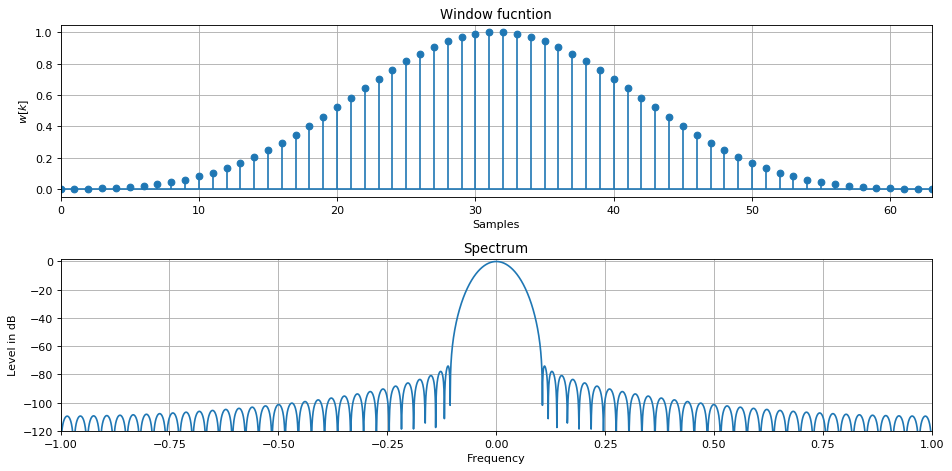

In [15]:
N = 64
dft_win(sig.kaiser(N, beta=10))

**Gauss Window**

The Gaussian window is defined by an exponential function and varies by the variance parameter (standard deviation).

$w(n) = e^{-\frac{1}{2}(\frac{n}{\sigma})^{2}}$


The frequency properties of the window depend on the $ \sigma $ parameter.

The more $ \ sigma $, the narrower the main lobe, but the higher the level of the side lobes (worse suppression).

In practice, the Gaussian window in the hardware is practically not implemented, but it is used in software, for example, in problems of calculating the FIR filter coefficients.

Python: `signal.gaussian (M, std)`

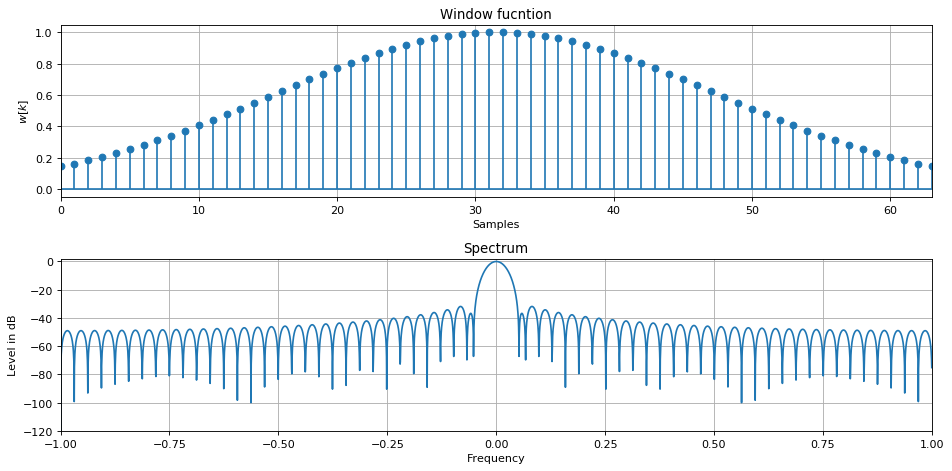

In [16]:
N = 64
dft_win(sig.gaussian(N, std=16))

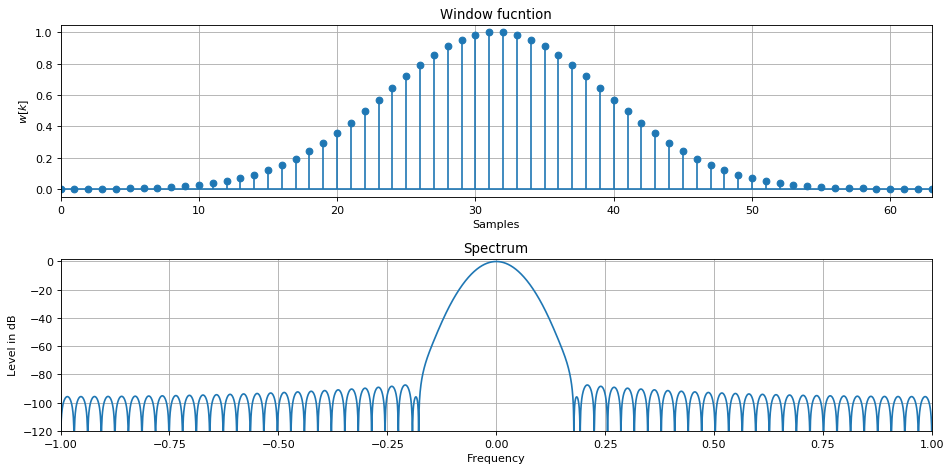

In [17]:
N = 64
dft_win(sig.gaussian(N, std=8))

We examined the basic window functions.

### numpy window functions

In the python numpy package, the set of window functions is limited.

- bartlett (M) is a triangular function,
- blackman (M) - Blackman function,
- hamming (M) - Hamming window,
- hanning (M) - Hanning or Hann window,
- kaiser (M, beta) - Kaiser window.
____

Unlike numpy, the scipy package expands the capabilities of window filtering, and, as was seen in the examples above, it complements the functionality. Here is a list of the main functions from the `scipy.signal` package

### scipy window functions

| **Function** | **Description** | **Side-Lobe Level** |
| --- | --- | --- |
| `boxcar (M [, sym])` | Rectangular Window | 13 |
| `triang (M [, sym])` | Triangular Window | 26 |
| `bartlett (M [, sym])` | Triangular window (Bartlett) | 26 |
| `cosine (M [, sym])` | Cosine window | 23 |
| `hann (M [, sym])` | Window Hannah (Henning) | 31.5 |
| `hanning (M [, sym])` | Hanning Window (Hannah) | 31.5 |
| `hamming (M [, sym])` | Hamming Window | 42 |
| `blackman (M [, sym])` | Blackman's Window | 58 |
| `blackmanharris (M [, sym])` | Blackman-Harris Function | 92 |
| `nuttall (M [, sym])` | Nattal Window | 93 |
| `flattop (M [, sym])` | Flat Top Window | 70 |
| `kaiser (M, beta [, sym])` | Kaiser Function (parameter - $ \beta $) | $ f (\beta) $ |
| `gaussian (M, std [, sym])` | Gauss function (parameter - $ \sigma $) | $ f (\sigma) $ |

## Basic window functions

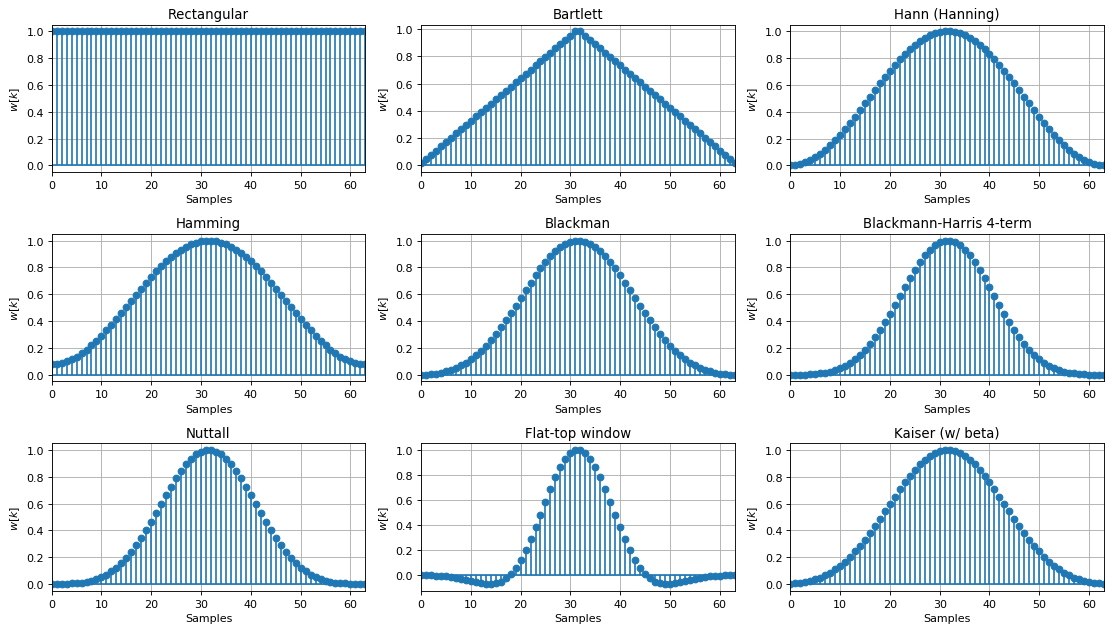

In [18]:
N = 64
# All windows
ww = np.zeros((N, 9))

ww[:,0] = np.ones(N)
ww[:,1] = sig.triang(N)
ww[:,2] = sig.hann(N)
ww[:,3] = sig.hamming(N)
ww[:,4] = sig.blackman(N)
ww[:,5] = sig.blackmanharris(N)
ww[:,6] = sig.nuttall(N)
ww[:,7] = sig.flattop(N)
ww[:,8] = sig.kaiser(N, beta=8)

lst_titles = ['Rectangular', 'Bartlett', 'Hann (Hanning)', 
              'Hamming', 'Blackman', 'Blackmann-Harris 4-term', 
              'Nuttall', 'Flat-top window', 'Kaiser (w/ beta)'
             ]

# Plot window function and its spectrum
fig = plt.figure(figsize=(14, 8), dpi=80)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.stem(ww[:,i], use_line_collection=True, basefmt='C0')
    plt.title(lst_titles[i])
    plt.xlabel('Samples')
    plt.ylabel(r'$w[k]$')
    plt.xlim([0, N-1])
    plt.grid(True)
plt.tight_layout()

## Spectra of basic window functions

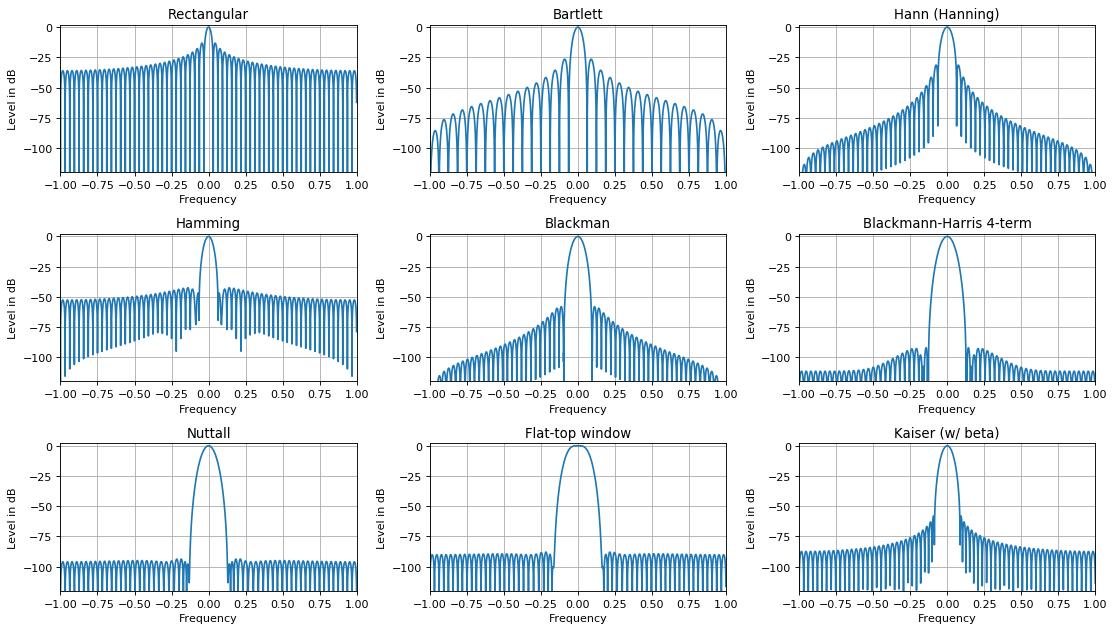

In [19]:
NFFT = 2**12
# Calculate FFT
WW = fft(ww, NFFT, axis=0)
WW = WW / np.amax(WW, axis=0) + np.nextafter(0,1)

tt = np.linspace(-1, 1, NFFT)

# Plot window function and its spectrum
fig2 = plt.figure(figsize=(14, 8), dpi=80)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(tt, 20*np.log10(np.abs(fftshift(WW[:,i]))))
    plt.title(lst_titles[i])
    plt.xlabel('Frequency')
    plt.ylabel('Level in dB')
    plt.axis([-1, 1, -120, 2])
    plt.grid(True)
plt.tight_layout()

## Search for weak signals

Earlier it was said that with the help of window filtering, it is possible to isolate weak signals against the background of stronger ones. Let us prove this by plotting the sum of two harmonic signals located close to each other in frequency and significantly differing in amplitude.

The following graph shows the spectrum without window filtering (the window is rectangular) and with the input signal filtered by the Kaiser window with the given parameter $ beta = 7 $

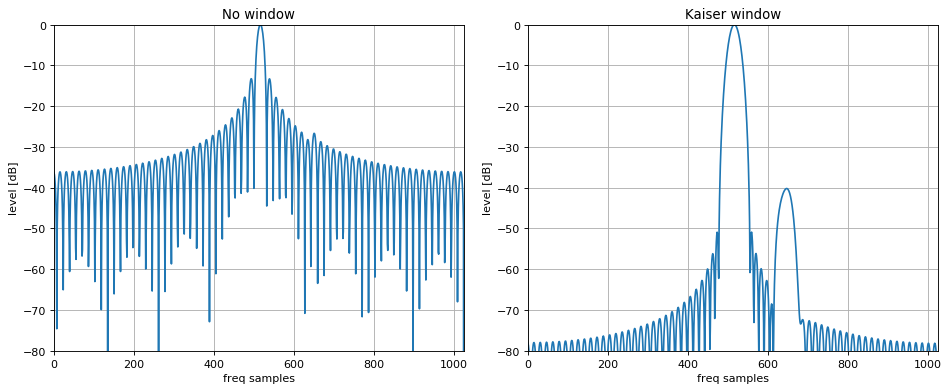

In [20]:
# Input parameters
N = 128
NFFT = 2048

# Input signal (long: N >> NFFT)
tt = np.linspace(0, 1, N, endpoint=True)
xx = 100*np.cos(2*np.pi*32*tt)+np.cos(2*np.pi*40*tt)

# Window (Kaiser)
wn = sig.kaiser(N, beta=7)
yy = xx*wn

# Calculate FFT 1
sft = np.abs(fft(xx, NFFT))
slg = 20*np.log10(sft / np.max(sft))

# Calculate FFT 2
yft = np.abs(fft(yy, NFFT))
ylg = 20*np.log10(yft / np.max(yft))

lst_ffts = [slg, ylg]
lst_wins = ['No window', 'Kaiser window']
plt.figure(figsize=(12, 5), dpi=80)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(lst_wins[i])
    plt.xlabel('freq samples')
    plt.ylabel('level [dB]')
    plt.plot(lst_ffts[i])
    plt.xlim([0, NFFT//2])
    plt.ylim([-80, 0])
    plt.grid(True)
plt.tight_layout()

As you can see in the previous figure, without a window function it is almost impossible to distinguish between a weak signal and a strong signal. However, using a window function with good suppression properties, it is possible to detect a weak signal against a strong one!